# <span style="font-width:bold; font-size: 3rem; color:#2656a3;">**Msc. BDS - M7 Second Semester Project** </span> <span style="font-width:bold; font-size: 3rem; color:#333;">- Part 03: Training Pipeline</span>

## <span style='color:#2656a3'> 🗒️ This notebook is divided into the following sections:
1. Feature selection.
2. Creating a Feature View.
3. Training datasets creation - splitting into train and test sets.
4. Training the model and model validation.
5. Register the model to Hopsworks Model Registry.

## <span style='color:#2656a3'> ⚙️ Import of libraries and packages
We start with importing some of the necessary libraries needed for this notebook and warnings to avoid unnecessary distractions and keep output clean.

In [1]:
# Importing the packages and libraries
import pandas as pd
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

## <span style="color:#2656a3;"> 📡 Connecting to Hopsworks Feature Store
We connect to Hopsworks Feature Store so we can retrieve the Feature Groups and select features for training data.

In [2]:
# Importing the hopsworks module for interacting with the Hopsworks platform
import hopsworks

# Logging into the Hopsworks project
project = hopsworks.login()

# Getting the feature store from the project
fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/550040
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
# Retrieve the feature groups
electricity_price_fg = fs.get_feature_group(
    name='electricity_spot_prices',
    version=1,
)

electricity_price_window_fg = fs.get_feature_group(
    name='electricity_spot_price_window',
    version=1,
)

weather_fg = fs.get_feature_group(
    name='weather_measurements',
    version=1,
)

danish_calendar_fg = fs.get_feature_group(
    name='calendar_denmark',
    version=1,
)

## <span style="color:#2656a3;"> 🖍 Feature View Creation and Retrieving </span>

We first select the features that we want to include for model training.

Since we specified `primary_key`as `date` and `timestamp` in `1_feature_backfill` we can now join them together for the `electricity_price_fg`, `electricity_price_window_fg`, `weather_fg` and `danish_calendar_fg`.

`join_type` specifies the type of join to perform. An inner join refers to only retaining the rows based on the keys present in all joined DataFrames.

In [4]:
# Select features for training data and join them together and except duplicate columns
selected_features = electricity_price_fg.select_all()\
    .join(electricity_price_window_fg.select_except(["timestamp", "datetime"]), join_type="inner")\
    .join(weather_fg.select_except(["timestamp", "datetime", "hour", "date"]), join_type="inner")\
    .join(danish_calendar_fg.select_except(["timestamp", "datetime", "hour", "date"]), join_type="inner")

In [5]:
# Display the first 5 rows of the selected features
selected_features.show(5)

Finished: Reading data from Hopsworks, using ArrowFlight (7.45s) 


,timestamp,datetime,date,hour,dk1_spotpricedkk_kwh,prev_1w_mean,prev_2w_mean,prev_4w_mean,prev_6w_mean,prev_8w_mean,...,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,workday
0,1640005200000,2021-12-20 13:00:00+00:00,2021-12-20 00:00:00+00:00,13,2.67335,1.297205,1.403636,1.316992,1.217807,1.097839,...,0.0,0.0,4.0,10.3,19.1,0,20,12,2021,1
1,1603846800000,2020-10-28 01:00:00+00:00,2020-10-28 00:00:00+00:00,1,0.01667,0.155875,0.193520,0.202099,0.224958,0.241531,...,0.0,53.0,100.0,20.8,42.1,2,28,10,2020,1
2,1651698000000,2022-05-04 21:00:00+00:00,2022-05-04 00:00:00+00:00,21,1.95963,1.607277,1.472573,1.299789,1.305915,1.317723,...,0.0,0.0,16.0,9.1,16.2,2,4,5,2022,1
3,1649995200000,2022-04-15 04:00:00+00:00,2022-04-15 00:00:00+00:00,4,1.42714,1.169467,1.065447,1.240337,1.493560,1.414573,...,0.0,3.0,90.0,13.0,24.1,4,15,4,2022,0
4,1645790400000,2022-02-25 12:00:00+00:00,2022-02-25 00:00:00+00:00,12,0.66911,0.662852,0.706345,0.773898,0.801796,0.825615,...,0.0,1.0,46.0,27.2,53.3,4,25,2,2022,1


A `Feature View` stands between the **Feature Groups** and **Training Dataset**. Сombining **Feature Groups** we can create a **Feature View** which stores a metadata of our data. Having the **Feature View** we can create a **Training Dataset**.

In order to create Feature View we can use `fs.get_or_create_feature_view()` method.

We can specify parameters:

- `name` - Name of the feature view to create.
- `version` - Version of the feature view to create.
- `query` - Query object with the data.

In [6]:
# Getting or creating a feature view named 'xgb_electricity_price_feature_view'
version=1
electricity_price_fw = fs.get_or_create_feature_view(
    name='xgb_electricity_price_feature_view',
    version=version,
    query=selected_features,
)

In [7]:
# Print the feature view as a string format
print(electricity_price_fw.query.to_string())

SELECT `fg3`.`timestamp` `timestamp`, `fg3`.`datetime` `datetime`, `fg3`.`date` `date`, `fg3`.`hour` `hour`, `fg3`.`dk1_spotpricedkk_kwh` `dk1_spotpricedkk_kwh`, `fg0`.`prev_1w_mean` `prev_1w_mean`, `fg0`.`prev_2w_mean` `prev_2w_mean`, `fg0`.`prev_4w_mean` `prev_4w_mean`, `fg0`.`prev_6w_mean` `prev_6w_mean`, `fg0`.`prev_8w_mean` `prev_8w_mean`, `fg0`.`prev_12w_mean` `prev_12w_mean`, `fg1`.`temperature_2m` `temperature_2m`, `fg1`.`relative_humidity_2m` `relative_humidity_2m`, `fg1`.`precipitation` `precipitation`, `fg1`.`rain` `rain`, `fg1`.`snowfall` `snowfall`, `fg1`.`weather_code` `weather_code`, `fg1`.`cloud_cover` `cloud_cover`, `fg1`.`wind_speed_10m` `wind_speed_10m`, `fg1`.`wind_gusts_10m` `wind_gusts_10m`, `fg2`.`dayofweek` `dayofweek`, `fg2`.`day` `day`, `fg2`.`month` `month`, `fg2`.`year` `year`, `fg2`.`workday` `workday`
FROM `camillah_featurestore`.`electricity_spot_prices_1` `fg3`
INNER JOIN `camillah_featurestore`.`electricity_spot_price_window_1` `fg0` ON `fg3`.`timestamp

## <span style="color:#2656a3;"> 🏋️ Training Dataset Creation</span>

In Hopsworks, a training dataset is generated from a query defined by the parent FeatureView, which determines the set of features.

**Training Dataset may contain splits such as:** 
* Training set: This subset of the training data is utilized for model training.
* Validation set: Used for evaluating hyperparameters during model training. *(We have not included a validation set for this project)*
* Test set: Reserved as a holdout subset of training data for evaluating a trained model's performance.

Training dataset is created using `fs.training_data()` method.

In [8]:
# Retrieve training data from the feature view 'electricity_price_fw', assigning the features to 'df'
df, _ = electricity_price_fw.training_data(
    description = 'Electricity Prices Training Dataset',
)

Finished: Reading data from Hopsworks, using ArrowFlight (4.81s) 


In [29]:
# Convert the 'date' and 'datetime' columns to datetime objects
df['date'] = pd.to_datetime(df['date']).dt.strftime("%Y-%m-%d")
df['datetime'] = pd.to_datetime(df['datetime']).dt.strftime('%Y-%m-%d %H:%M:%S')

df['date'] = pd.to_datetime(df['date'])
df['datetime'] = pd.to_datetime(df['datetime'])

# Show information about the dataframe to confirm the adjustments
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38549 entries, 0 to 38548
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   timestamp             38549 non-null  int64         
 1   datetime              38549 non-null  datetime64[ns]
 2   date                  38549 non-null  datetime64[ns]
 3   hour                  38549 non-null  int64         
 4   dk1_spotpricedkk_kwh  38549 non-null  float64       
 5   prev_1w_mean          38549 non-null  float64       
 6   prev_2w_mean          38549 non-null  float64       
 7   prev_4w_mean          38549 non-null  float64       
 8   prev_6w_mean          38549 non-null  float64       
 9   prev_8w_mean          38549 non-null  float64       
 10  prev_12w_mean         38549 non-null  float64       
 11  temperature_2m        38549 non-null  float64       
 12  relative_humidity_2m  38549 non-null  float64       
 13  precipitation   

In [10]:
# Sorting the dataframe by timestamp for better performance for temporal models
df.sort_values(by='timestamp', ascending=True, inplace=True)

# Resetting the index of the dataframe
df = df.reset_index(drop=True)

# Display the first 5 rows of the training data
df.head(5)

,timestamp,datetime,date,hour,dk1_spotpricedkk_kwh,prev_1w_mean,prev_2w_mean,prev_4w_mean,prev_6w_mean,prev_8w_mean,...,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,workday
0,1577836800000,2020-01-01 00:00:00,2020-01-01,0,0.24965,0.249650,0.249650,0.249650,0.249650,0.249650,...,0.0,1.0,25.0,18.4,33.8,2,1,1,2020,0
1,1577840400000,2020-01-01 01:00:00,2020-01-01,1,0.23733,0.243490,0.243490,0.243490,0.243490,0.243490,...,0.0,0.0,15.0,18.0,35.3,2,1,1,2020,0
2,1577844000000,2020-01-01 02:00:00,2020-01-01,2,0.23583,0.240937,0.240937,0.240937,0.240937,0.240937,...,0.0,2.0,51.0,19.0,36.4,2,1,1,2020,0
3,1577847600000,2020-01-01 03:00:00,2020-01-01,3,0.23366,0.239118,0.239118,0.239118,0.239118,0.239118,...,0.0,2.0,77.0,21.1,41.0,2,1,1,2020,0
4,1577851200000,2020-01-01 04:00:00,2020-01-01,4,0.23045,0.237384,0.237384,0.237384,0.237384,0.237384,...,0.0,3.0,100.0,21.5,42.8,2,1,1,2020,0


### <span style="color:#2656a3;">👆 Feature Selection and Preprocessing</span>

In [11]:
# Define the features and target variable

# Drop the columns 'date', 'datetime', and 'timestamp' from the original dataframe
X = df.drop(columns=['date', 'datetime', 'timestamp'])

# Assign the target variable to 'y'
y = X.pop('dk1_spotpricedkk_kwh')

### <span style="color:#2656a3;"> ⛳️ Dataset with Train and Test Splits</span>

Here we define our train and test splits for traning the model.

In [12]:
# Splitting the time-series data into training and testing sets

# Defining the size of the training set as 80% of the data
train_size = int(len(df) * 0.8)

# Defining the size of the test set as the remaining 20% of the data
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

In [13]:
# Show information about the training data to confirm the adjestments
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30839 entries, 0 to 30838
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   hour                  30839 non-null  int64  
 1   prev_1w_mean          30839 non-null  float64
 2   prev_2w_mean          30839 non-null  float64
 3   prev_4w_mean          30839 non-null  float64
 4   prev_6w_mean          30839 non-null  float64
 5   prev_8w_mean          30839 non-null  float64
 6   prev_12w_mean         30839 non-null  float64
 7   temperature_2m        30839 non-null  float64
 8   relative_humidity_2m  30839 non-null  float64
 9   precipitation         30839 non-null  float64
 10  rain                  30839 non-null  float64
 11  snowfall              30839 non-null  float64
 12  weather_code          30839 non-null  float64
 13  cloud_cover           30839 non-null  float64
 14  wind_speed_10m        30839 non-null  float64
 15  wind_gusts_10m     

## <span style="color:#2656a3;">🧬 Modeling</span>

For Modeling we initialize the `XGBoost Regressor`.

The XGBoost Regressor is a powerful and versatile algorithm known for its effectiveness in a wide range of regression tasks, including predictive modeling and time series forecasting. Specifically tailored for regression tasks, it aims to predict continuous numerical values. The algorithm constructs an ensemble of regression trees, optimizing them to minimize a specified loss function, commonly the mean squared error for regression tasks. Ultimately, the final prediction is derived by aggregating the predictions of individual trees.

### <span style="color:#2656a3;">🏠 Model Building</span>

In [14]:
# Importing the XGBoost model
from xgboost import XGBRegressor

# Training the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror')

### <span style="color:#2656a3;">💪 Model Training</span>

In [15]:
# Fitting the model to the training data
xgb_model.fit(X_train, y_train)

See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### <span style="color:#2656a3;">🤖 Making the Predictions</span>

To provide a non-technical performance overview, we extract the predicted prices and actual prices of the last five values for a quick performance overview.

In [16]:
# Use the model to make predictions on the feature set X and assign these predictions to a new column 'predictions' in the dataframe df
df['predictions'] = xgb_model.predict(X)

# Show the last 5 rows of the dataframe with the predictions and the actual values
df[['datetime', 'dk1_spotpricedkk_kwh', 'predictions']].tail()

,datetime,dk1_spotpricedkk_kwh,predictions
38544,2024-05-26 05:00:00,0.66118,0.360993
38545,2024-05-26 06:00:00,0.62298,0.361774
38546,2024-05-26 07:00:00,0.53649,0.368297
38547,2024-05-26 08:00:00,0.09887,0.324221
38548,2024-05-26 09:00:00,0.00015,0.301910


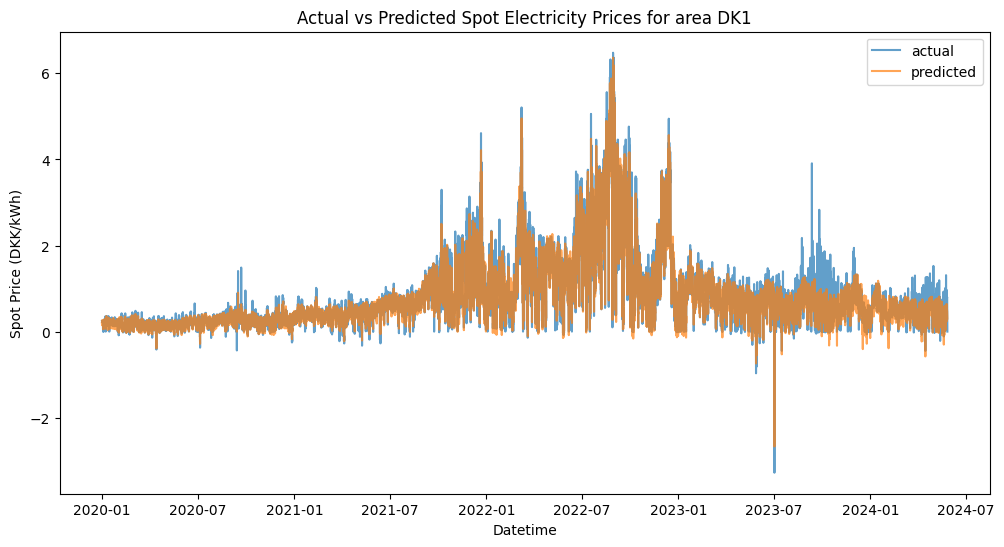

In [17]:
# Plot the predicted and actual values
plt.figure(figsize=(12, 6))
plt.plot(df['datetime'], df['dk1_spotpricedkk_kwh'], label='actual', alpha=0.7)
plt.plot(df['datetime'], df['predictions'], label='predicted', alpha=0.7)

# Adding labels and title
plt.title('Actual vs Predicted Spot Electricity Prices for area DK1')
plt.xlabel('Datetime')
plt.ylabel('Spot Price (DKK/kWh)')

# Add a legend and display the plot
plt.legend()
plt.show()

## <span style='color:#2656a3'> ⚖️ Model Validation

After fitting the XGBoost Regressor, we evaluate the performance using the following validation metrics.

**Mean Squared Error (MSE):**
- Measures the average squared difference between the actual and predicted values in a regression problem. 
- It squares the differences between predicted and actual values to penalize larger errors more heavily.
- Lower MSE values indicate better model performance.

**Mean Absolute Error (MAE):**
- Measures the average absolute difference between the actual and predicted values.
- MAE is less sensitive to outliers compared to MSE because it does not square the errors.
- Like MSE and RMSE, lower MAE values indicate better model performance.

**Root Mean Squared Error (RMSE):**
- RMSE is the square root of the average squared difference between the actual values and the predicted values.
- RMSE is in the same units as the original data, making it more interpretable compared to MSE. RMSE penalizes larger errors more than MAE because it involves taking the square root of the average squared differences. 
- Lower RMSE values indicate better model performance,

MSE emphasizes larger errors more due to squaring, MAE gives equal weight to all errors, and RMSE combines the benefits of both MSE and MAE while maintaining interpretability.

In [31]:
# Importing the model validation metric functions from the sklearn library
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error

In [19]:
# Predict target values on the test set
y_pred = xgb_model.predict(X_test)

# Calculate Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test, y_pred)
print("⛳️ MSE:", mse)

# Calculate Mean Absolute Error (MAE) using sklearn
mae = mean_absolute_error(y_test, y_pred)
print("⛳️ MAE:", mae)

# Calculate Root Mean Squared Error (RMSE) using sklearn
rmse = root_mean_squared_error(y_test, y_pred)
print("⛳️ RMSE:", rmse)


⛳️ MSE: 0.04571252440037519
⛳️ MAE: 0.16051653590163548
⛳️ RMSE: 0.21380487459451245


See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)


In this case, the `MSE` is 0.046, which suggests that on average, the squared difference between the actual and predicted values is relatively low. A `MAE` of 0.161 suggests that, on average, the model's predictions are off by approximately 0.173 units from the actual values. Similar to MSE, a lower MAE indicates better accuracy of the model. An `RMSE` value of 0.214 suggests that, on average, the model's predictions are reasonably close to the actual values.

These evaluation measures collectively provide insights into the performance of the model. They suggest that the model's predictions are relatively close to the actual values, as indicated by the low values of MSE, MAE, and RMSE.

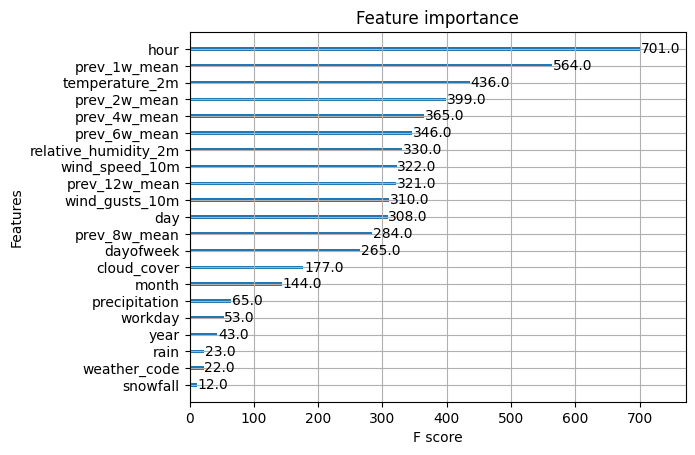

In [20]:
# Import the plot_importance function from XGBoost
from xgboost import plot_importance

# Plot feature importances using the plot_importance function from XGBoost
plot_importance(
    xgb_model, 
    max_num_features=25,  # Display the top 25 most important features
)
plt.show()

As shown in the above feature importance plot features like `hour` and the generated moving averages are among the most important for predicting the dependent variable. 

## <span style='color:#2656a3'>🗄 Model Registry</span>

The Model Registry in Hopsworks enable us to store the trained model. The model registry centralizes model management, enabling models to be securely accessed and governed. We can also save model metrics with the model, enabling the user to understand performance of the model on test (or unseen) data.

In [21]:
# Importing the libraries for saving the model
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib

# Imoprt the os library to interact with the operating system
import os

In [22]:
# Retrieving the Model Registry from Hopsworks
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


### <span style="color:#2656a3;">⚙️ Model Schema</span>
A model schema defines the structure and format of the input and output data that a machine learning model expects and produces, respectively. It serves as a **blueprint** for understanding how to interact with the model in terms of input features and output predictions. In the context of the Hopsworks platform, a model schema is typically defined using the Schema class, which specifies the features expected in the input data and the target variable in the output data. This schema helps ensure consistency and compatibility between the model and the data it operates on.

In [23]:
# Specify the schema of the model's input and output using the features (X_train) and dependent variable (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Create a model schema using the input and output schemas
model_schema = ModelSchema(input_schema, output_schema)

In [24]:
# Define the directory path (folder path) where the trained model will be exported
model_dir = "xgb_electricity_price_model"

# Check if the directory already exists, if not create it
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

In [25]:
# Save the XGBoost Regressor model as joblib file in the model directory
joblib.dump(xgb_model, model_dir + "/xgb_electricity_price_model.pkl")

['xgb_electricity_price_model/xgb_electricity_price_model.pkl']

In [26]:
# Create an entry in the model registry with the specified details 
xgb_model = mr.python.create_model(
    name="xgb_electricity_price_model", # Name of the model
    metrics={ # Evaluation metrics for the model
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse
    },
    model_schema=model_schema, # Schema defining the input and output data structure of the model
    input_example=X_train.sample(), # Example input data for the model
    description="DK1 Electricity Price Predictor with XGB" # Description of the model
)

In [27]:
# Upload the model to Hopsworks
xgb_model.save(model_dir)

Uploading: 100.000%|██████████| 447337/447337 elapsed<00:02 remaining<00:00  2.96it/s]
Uploading input_example and model_schema:  33%|███▎      | 2/6 [00:02<00:05,  1.48s/it]DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
Uploading: 100.000%|██████████| 204/204 elapsed<00:01 remaining<00:00
Uploading: 100.000%|██████████| 1722/1722 elapsed<00:01 remaining<00:00
Model export complete: 100%|██████████| 6/6 [00:11<00:00,  1.90s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/550040/models/xgb_electricity_price_model/2


Model(name: 'xgb_electricity_price_model', version: 2)

## <span style="color:#2656a3;">⏭️ **Next:** Part 04: Inference Pipeline </span>

Next we will use the registered model to make predictions based on new data in the `4_1_inference_pipeline_xgb` notebook.